In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

from pprint import pprint
import pickle

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Masking

# map district name to district number
district_mapping_path = "../airflow/dags/data/districts.xlsx"

district_mapping = pd.read_excel(district_mapping_path)


def get_district_name(district_no):
    return district_mapping[district_mapping["Postal District"] == district_no][
        "General Location"
    ].values[0]

# Import Previous Files

In [72]:
# Import all previous files
# open pickle
train_df_dict = pd.read_pickle('data/train_df_dict.pkl')
train_df_dict_L = pd.read_pickle('data/train_df_dict_L.pkl')
test_df_dict = pd.read_pickle('data/test_df_dict.pkl')

lookback = 6

# import resale_flat_transactions_clean
resale_flat_transactions_clean = pd.read_csv('data/resale_flat_transactions_clean.csv')

# import features 
all_district_var_ts = pd.read_pickle('data/all_district_var_ts.pkl')
all_district_var_ts_LI = pd.read_pickle('data/all_district_var_ts_LI.pkl')

# replace NaN values with 0 since we are using LSTM
# Mask layer will mask the 0 values
# merge the train set with the features
train_lstm_df_dict = {}
for district_no, district_df in train_df_dict.items():
    train_lstm_df_dict[district_no] = district_df.to_frame().merge(all_district_var_ts[district_no], left_index=True, right_index=True, how='left')
    # replace the NaN values with 0
    train_lstm_df_dict[district_no] = train_lstm_df_dict[district_no].fillna(0)

train_lstm_df_dict_L = {}
for district_no, district_df in train_df_dict_L.items():
    train_lstm_df_dict_L[district_no] = district_df.to_frame().merge(all_district_var_ts_LI[district_no], left_index=True, right_index=True, how='left')

# merge the test set with the features
test_lstm_df_dict = {}
for district_no, district_df in test_df_dict.items():
    test_lstm_df_dict[district_no] = district_df.to_frame().merge(all_district_var_ts[district_no], left_index=True, right_index=True, how='left')
    # replace the NaN values with 0
    test_lstm_df_dict[district_no] = test_lstm_df_dict[district_no].fillna(0)


# Normalize the data for training

In [73]:
# Normalize the data
# create scalers for each district
scaler_dict = {}
for district_no, district_df in train_lstm_df_dict.items():
    scaler_dict[district_no] = MinMaxScaler(feature_range=(0, 1))
    scaler_dict[district_no].fit(district_df)

# create scalers for each district
scaler_dict_L = {}
for district_no, district_df in train_lstm_df_dict_L.items():
    scaler_dict_L[district_no] = MinMaxScaler(feature_range=(0, 1))
    scaler_dict_L[district_no].fit(district_df)

# transform the train set
train_lstm_df_dict_scaled = {}
for district_no, district_df in train_lstm_df_dict.items():
    train_lstm_df_dict_scaled[district_no] = pd.DataFrame(
        scaler_dict[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# transform the train set
train_lstm_df_dict_scaled_L = {}
for district_no, district_df in train_lstm_df_dict_L.items():
    train_lstm_df_dict_scaled_L[district_no] = pd.DataFrame(
        scaler_dict_L[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# transform the test set
test_lstm_df_dict_scaled = {}
for district_no, district_df in test_lstm_df_dict.items():
    test_lstm_df_dict_scaled[district_no] = pd.DataFrame(
        scaler_dict[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# Format Data for LSTM

In [74]:
# convert all data

# create dataset for each district
train_lstm_dataset_dict = {}
for district_no, district_df in train_lstm_df_dict_scaled.items():
    train_lstm_dataset_dict[district_no] = TimeseriesGenerator(district_df.values, district_df.values, length=lookback, batch_size=1)

# create dataset for each district
train_lstm_dataset_dict_L = {}
for district_no, district_df in train_lstm_df_dict_scaled_L.items():
    train_lstm_dataset_dict_L[district_no] = TimeseriesGenerator(district_df.values, district_df.values, length=lookback, batch_size=1)

# create dataset for each district
test_lstm_dataset_dict = {}
for district_no, district_df in test_lstm_df_dict_scaled.items():
    test_lstm_dataset_dict[district_no] = TimeseriesGenerator(district_df.values, district_df.values, length=lookback, batch_size=1)

num_features = len(train_lstm_df_dict_scaled[1].columns)


In [75]:
# check generator dimensions
for i in range(len(test_lstm_dataset_dict[1])):
    x, y = test_lstm_dataset_dict[1][i]
    print(x.shape, y.shape)
print(len(test_lstm_dataset_dict[1]))

len(test_lstm_df_dict_scaled[1])

(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
18


24

# LSTM Model on district 1

In [76]:
def fit_lstm(train):
    model = Sequential()
    model.add( 
        Masking(
            mask_value=0.,
            input_shape=(
                lookback,
                num_features,
            ),
        )
    ) # mask the 0 values
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer="adam")
    model.fit(
        train,
        epochs=20,
        batch_size=8, 
        verbose=1 # type: ignore
    )

    return model



model_1 = fit_lstm(train_lstm_dataset_dict[1])


Epoch 1/20


2023-04-06 14:55:03.825725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 14:55:05.683556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 14:55:07.512585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 14:55:09.130160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 14:55:11.707391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 14:55:14.213671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 14:55:16.651291: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 120s 3s/step - loss: 0.1897
Epoch 2/20
33/33 [==============================] - 15s 438ms/step - loss: 0.1597
Epoch 3/20
33/33 [==============================] - 9s 280ms/step - loss: 0.1551
Epoch 4/20
33/33 [==============================] - 8s 235ms/step - loss: 0.1583
Epoch 5/20
33/33 [==============================] - 7s 220ms/step - loss: 0.1575
Epoch 6/20
33/33 [==============================] - 7s 225ms/step - loss: 0.1557
Epoch 7/20
33/33 [==============================] - 7s 220ms/step - loss: 0.1488
Epoch 8/20
33/33 [==============================] - 8s 234ms/step - loss: 0.1489
Epoch 9/20
33/33 [==============================] - 8s 235ms/step - loss: 0.1455
Epoch 10/20
33/33 [==============================] - 8s 232ms/step - loss: 0.1448
Epoch 11/20
33/33 [==============================] - 8s 237ms/step - loss: 0.1455
Epoch 12/20
33/33 [==============================] - 8s 240ms/step - loss: 0.1407
Epoch 13/20
33/33 [=================

## Get predictions and plot

In [77]:
# get the predictions
predictions = model_1.predict(test_lstm_dataset_dict[1])

print(predictions.shape) 
# number of predictions is 3 less than the number of test data because of the lookback. 
# This means that the predictions needs to be shifted by 3 months

# pad the predictions with 0 
predictions_padded = np.zeros((len(predictions), num_features)) # add dimension for the number of features
predictions_padded[:, 0] = predictions[:, 0] # fill the first column with the predictions

# inverse transform the predictions
predictions_inversed = scaler_dict[1].inverse_transform(predictions_padded) # correct shape for inverse transform

print(test_lstm_df_dict_scaled[1].shape) # test data shape


2023-04-06 14:59:34.555243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 14:59:35.766982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 14:59:38.983889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 14:59:42.599267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 50s 2s/step
(18, 1)
(24, 10)


In [78]:
def evaluate_lstm(model, X_train, X_test, district_no, lookback):
    # make predictions
    yhat_train = model.predict(X_train)
    yhat_test = model.predict(X_test)

    # pad the predictions
    yhat_train_padded = np.zeros((len(yhat_train), num_features))
    yhat_train_padded[:, 0] = yhat_train[:, 0]
    yhat_test_padded = np.zeros((len(yhat_test), num_features))
    yhat_test_padded[:, 0] = yhat_test_padded[:, 0]
    
    # inverse transform the predictions
    yhat_train_inversed = scaler_dict[district_no].inverse_transform(yhat_train_padded)
    yhat_test_inversed = scaler_dict[district_no].inverse_transform(yhat_test_padded)
    print("yhat train shape", yhat_train_inversed.shape)
    print("yhat test shape", yhat_test_inversed.shape)

    # take values only
    yhat_train_inversed = yhat_train_inversed[:, 0] 
    yhat_test_inversed = yhat_test_inversed[:, 0]

    # ground truth
    y_train = train_lstm_df_dict[district_no]['resale_price'].values[lookback:] # remove the first lookback months
    y_test = test_lstm_df_dict[district_no]['resale_price'].values[lookback:] # remove the first lookback months
    print("y train shape", y_train.shape)
    print("y test shape", y_test.shape)

    train_score = math.sqrt(mean_squared_error(y_train, yhat_train_inversed))
    print('Train Score: %.2f RMSE' % (train_score))
    test_score = math.sqrt(mean_squared_error(y_test, yhat_test_inversed))
    print('Test Score: %.2f RMSE' % (test_score))

    try: 
        # set index of the predictions 
        yhat_train_df = pd.DataFrame(yhat_train_inversed, index=train_lstm_df_dict[1].index[lookback:])
        yhat_test_df = pd.DataFrame(yhat_test_inversed, index=test_lstm_df_dict[1].index[lookback:])
    except:
        print(f'model for district {district_no} cannot be evaluated')
        return None

    # plot baseline and predictions
    plt.plot(train_lstm_df_dict[district_no]['resale_price'], label="y_train", marker='o')
    plt.plot(test_lstm_df_dict[district_no]['resale_price'], label="y_test", marker='o')
    plt.plot(yhat_train_df, label="yhat_train", marker='o')
    plt.plot(yhat_test_df, label="yhat_test", marker='o')
    plt.legend()
    plt.show()

    return test_score


18/18 [==============================] - 1s 58ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 179977.54 RMSE
Test Score: 452249.19 RMSE


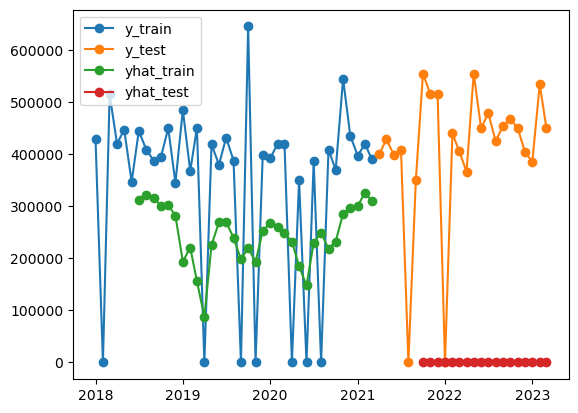

452249.18831694254

In [79]:
evaluate_lstm(
    model=model_1,
    X_train=train_lstm_dataset_dict[1],
    X_test=test_lstm_dataset_dict[1],
    district_no=1,
    lookback=lookback,
)


# LSTM on all districts

district_no 1
Epoch 1/20


2023-04-06 15:00:52.544325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:00:55.495497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:00:59.540570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:01:03.062177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:01:07.695939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:01:11.720246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:01:15.656372: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 159s 4s/step - loss: 0.1847
Epoch 2/20
33/33 [==============================] - 23s 662ms/step - loss: 0.1672
Epoch 3/20
33/33 [==============================] - 9s 280ms/step - loss: 0.1583
Epoch 4/20
33/33 [==============================] - 8s 242ms/step - loss: 0.1588
Epoch 5/20
33/33 [==============================] - 8s 233ms/step - loss: 0.1504
Epoch 6/20
33/33 [==============================] - 8s 248ms/step - loss: 0.1483
Epoch 7/20
33/33 [==============================] - 8s 239ms/step - loss: 0.1498
Epoch 8/20
33/33 [==============================] - 8s 248ms/step - loss: 0.1453
Epoch 9/20
33/33 [==============================] - 8s 233ms/step - loss: 0.1420
Epoch 10/20
33/33 [==============================] - 8s 230ms/step - loss: 0.1421
Epoch 11/20
33/33 [==============================] - 8s 233ms/step - loss: 0.1539
Epoch 12/20
33/33 [==============================] - 8s 227ms/step - loss: 0.1436
Epoch 13/20
33/33 [=================

2023-04-06 15:06:09.758641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:06:10.834722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:06:13.036062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:06:15.063995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 4s 233ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 162556.44 RMSE
Test Score: 452249.19 RMSE


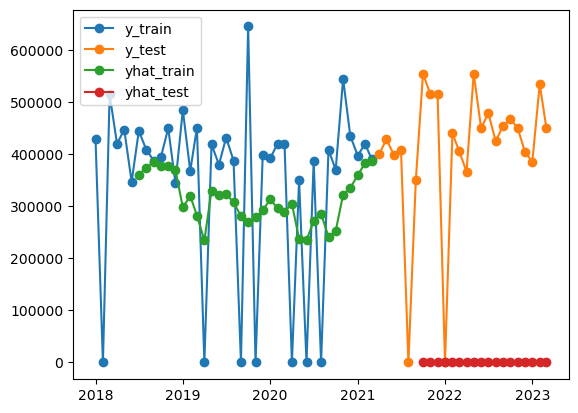

district_no 2
Epoch 1/20


2023-04-06 15:07:10.250438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:07:12.351685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:07:14.288691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:07:17.376646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:07:21.117615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:07:24.433709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:07:27.787847: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 129s 3s/step - loss: 0.2086
Epoch 2/20
33/33 [==============================] - 16s 398ms/step - loss: 0.1573
Epoch 3/20
33/33 [==============================] - 7s 202ms/step - loss: 0.1570
Epoch 4/20
33/33 [==============================] - 5s 142ms/step - loss: 0.1558
Epoch 5/20
33/33 [==============================] - 3s 86ms/step - loss: 0.1540
Epoch 6/20
33/33 [==============================] - 4s 120ms/step - loss: 0.1536
Epoch 7/20
33/33 [==============================] - 3s 98ms/step - loss: 0.1565
Epoch 8/20
33/33 [==============================] - 3s 97ms/step - loss: 0.1537
Epoch 9/20
33/33 [==============================] - 3s 85ms/step - loss: 0.1552
Epoch 10/20
33/33 [==============================] - 3s 78ms/step - loss: 0.1558
Epoch 11/20
33/33 [==============================] - 3s 80ms/step - loss: 0.1547
Epoch 12/20
33/33 [==============================] - 3s 85ms/step - loss: 0.1543
Epoch 13/20
33/33 [========================

2023-04-06 15:10:30.859631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:10:32.378423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:10:34.393230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:10:36.918866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 20ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 339420.45 RMSE
Test Score: 942151.45 RMSE


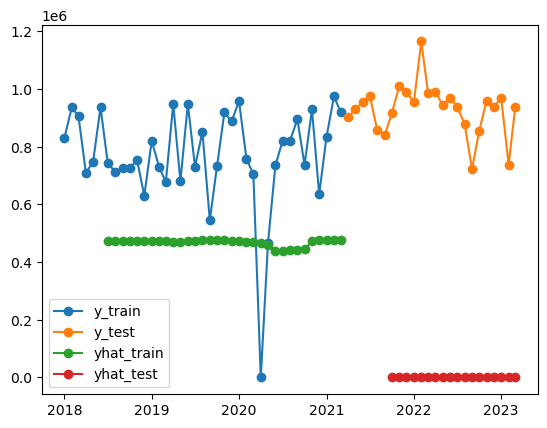

district_no 3
Epoch 1/20


2023-04-06 15:11:21.750074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:11:23.567447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:11:26.309024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:11:27.928658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:11:30.653281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:11:32.960455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:11:37.173252: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 81s 2s/step - loss: 0.1086
Epoch 2/20
33/33 [==============================] - 4s 101ms/step - loss: 0.0998
Epoch 3/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0964
Epoch 4/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0944
Epoch 5/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0938
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0959
Epoch 7/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0934
Epoch 8/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0947
Epoch 9/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0941
Epoch 10/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0963
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0934
Epoch 12/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0931
Epoch 13/20
33/33 [=============================

2023-04-06 15:13:10.235221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:13:11.798549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:13:14.462352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:13:16.681884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 2s 83ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 57819.04 RMSE
Test Score: 187180.72 RMSE


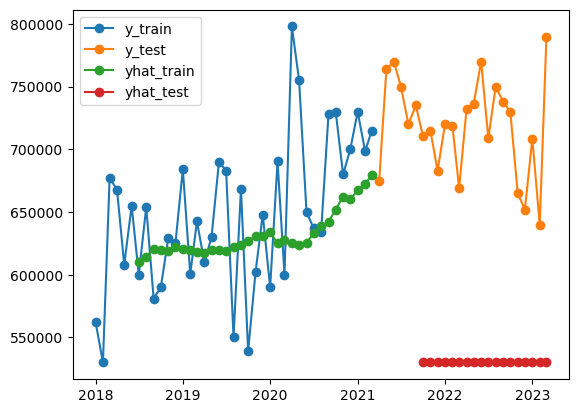

district_no 4
Epoch 1/20


2023-04-06 15:14:05.557554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:14:09.531115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:14:13.157695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:14:15.385244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:14:19.973147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:14:23.471807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:14:26.701817: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 92s 2s/step - loss: 0.0949
Epoch 2/20
33/33 [==============================] - 3s 78ms/step - loss: 0.0796
Epoch 3/20
33/33 [==============================] - 2s 59ms/step - loss: 0.0810
Epoch 4/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0807
Epoch 5/20
33/33 [==============================] - 2s 50ms/step - loss: 0.0795
Epoch 6/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0793
Epoch 7/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0791
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0797
Epoch 9/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0787
Epoch 10/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0790
Epoch 11/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0795
Epoch 12/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0796
Epoch 13/20
33/33 [==============================

2023-04-06 15:16:02.408327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:16:03.883764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:16:05.560444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:16:07.521954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 34ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 79973.57 RMSE
Test Score: 270948.23 RMSE


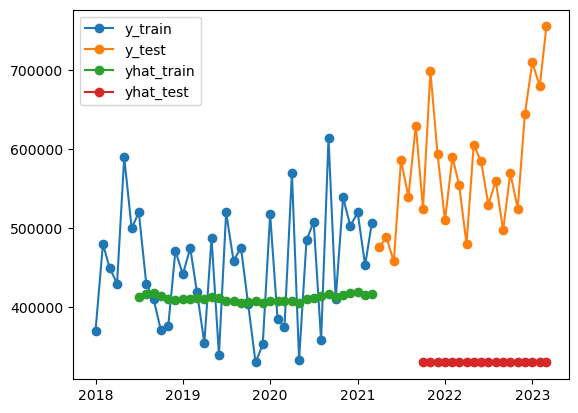

district_no 5
Epoch 1/20


2023-04-06 15:16:36.824808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:16:38.530886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:16:40.715528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:16:42.986701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:16:47.097113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:16:50.376965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:16:53.428573: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 77s 2s/step - loss: 0.1154
Epoch 2/20
33/33 [==============================] - 2s 67ms/step - loss: 0.0976
Epoch 3/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0972
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1021
Epoch 5/20
33/33 [==============================] - 2s 45ms/step - loss: 0.0955
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0985
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0949
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0955
Epoch 9/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0957
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0959
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0952
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0949
Epoch 13/20
33/33 [==============================

2023-04-06 15:18:18.809731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:18:20.092775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:18:21.580589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:18:23.117851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 18ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 68294.74 RMSE
Test Score: 244527.72 RMSE


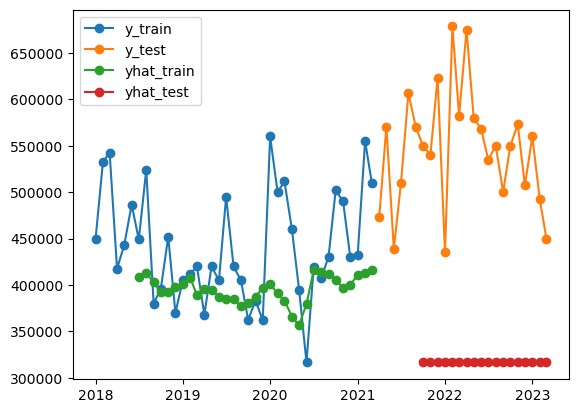

district_no 7
Epoch 1/20


2023-04-06 15:18:55.294799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:18:57.170286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:18:58.782238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:19:01.336729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:19:04.490728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:19:06.770946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:19:09.252554: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 110s 3s/step - loss: 0.2052
Epoch 2/20
33/33 [==============================] - 15s 472ms/step - loss: 0.1627
Epoch 3/20
33/33 [==============================] - 6s 195ms/step - loss: 0.1576
Epoch 4/20
33/33 [==============================] - 6s 200ms/step - loss: 0.1603
Epoch 5/20
33/33 [==============================] - 4s 110ms/step - loss: 0.1583
Epoch 6/20
33/33 [==============================] - 4s 128ms/step - loss: 0.1544
Epoch 7/20
33/33 [==============================] - 3s 86ms/step - loss: 0.1537
Epoch 8/20
33/33 [==============================] - 3s 78ms/step - loss: 0.1579
Epoch 9/20
33/33 [==============================] - 4s 111ms/step - loss: 0.1551
Epoch 10/20
33/33 [==============================] - 3s 84ms/step - loss: 0.1530
Epoch 11/20
33/33 [==============================] - 3s 88ms/step - loss: 0.1510
Epoch 12/20
33/33 [==============================] - 3s 87ms/step - loss: 0.1558
Epoch 13/20
33/33 [======================

2023-04-06 15:22:00.072079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:22:01.170557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:22:02.745013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:22:04.037873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 152885.42 RMSE
Test Score: 478284.92 RMSE


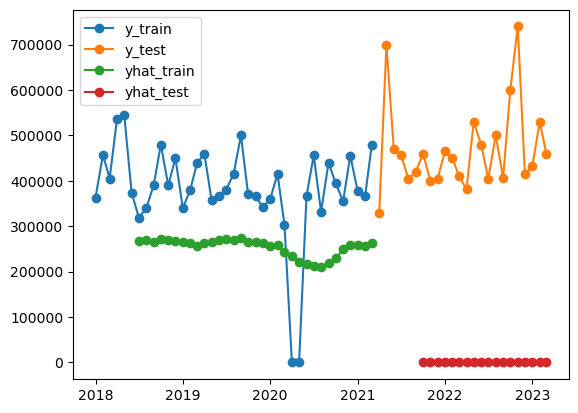

district_no 8
Epoch 1/20


2023-04-06 15:22:53.057539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:22:55.577048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:22:58.506230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:23:01.603004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:23:07.193059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:23:10.637038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:23:15.192504: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 191s 5s/step - loss: 0.1507
Epoch 2/20
33/33 [==============================] - 18s 553ms/step - loss: 0.1334
Epoch 3/20
33/33 [==============================] - 10s 307ms/step - loss: 0.1326
Epoch 4/20
33/33 [==============================] - 5s 149ms/step - loss: 0.1321
Epoch 5/20
33/33 [==============================] - 3s 99ms/step - loss: 0.1332
Epoch 6/20
33/33 [==============================] - 4s 127ms/step - loss: 0.1321
Epoch 7/20
33/33 [==============================] - 4s 109ms/step - loss: 0.1295
Epoch 8/20
33/33 [==============================] - 3s 93ms/step - loss: 0.1308
Epoch 9/20
33/33 [==============================] - 3s 78ms/step - loss: 0.1304
Epoch 10/20
33/33 [==============================] - 3s 85ms/step - loss: 0.1307
Epoch 11/20
33/33 [==============================] - 3s 84ms/step - loss: 0.1287
Epoch 12/20
33/33 [==============================] - 3s 78ms/step - loss: 0.1295
Epoch 13/20
33/33 [======================

2023-04-06 15:27:21.366831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:27:22.694495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:27:24.562100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:27:26.806953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 2s 104ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 163788.37 RMSE
Test Score: 572042.35 RMSE


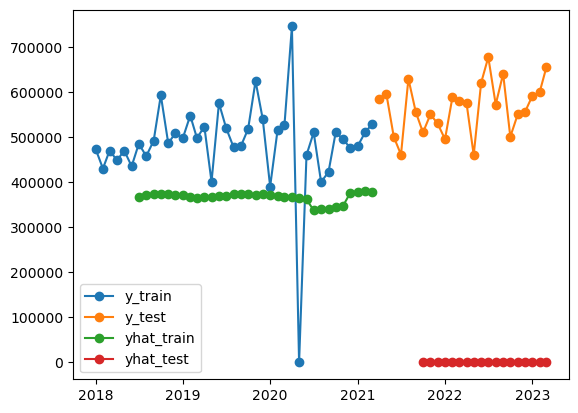

district_no 10
Epoch 1/20


2023-04-06 15:28:14.129301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:28:16.294663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:28:18.647790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:28:21.154332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:28:25.519463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:28:29.638109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:28:33.281327: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 98s 2s/step - loss: 0.0698
Epoch 2/20
33/33 [==============================] - 3s 97ms/step - loss: 0.0642
Epoch 3/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0656
Epoch 4/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0656
Epoch 5/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0635
Epoch 6/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0647
Epoch 7/20
33/33 [==============================] - 2s 48ms/step - loss: 0.0635
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0631
Epoch 9/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0625
Epoch 10/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0635
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0638
Epoch 12/20
33/33 [==============================] - 2s 51ms/step - loss: 0.0639
Epoch 13/20
33/33 [==============================

2023-04-06 15:30:19.570339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:30:20.956359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:30:23.248411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:30:25.451961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 39ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 67956.45 RMSE
Test Score: 275993.26 RMSE


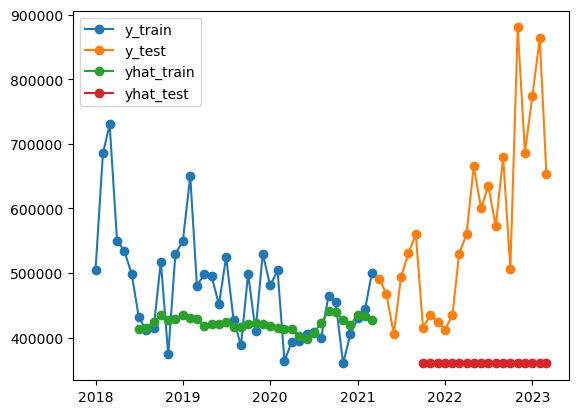

district_no 11
Epoch 1/20


2023-04-06 15:31:03.950697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:31:06.204578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:31:10.412084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:31:13.987643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:31:19.367096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:31:24.790561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:31:28.493301: I tensorflow/core/grappler/optimizers/cust

21/21 [==============================] - 153s 6s/step - loss: 0.1290
Epoch 2/20
21/21 [==============================] - 15s 742ms/step - loss: 0.1239
Epoch 3/20
21/21 [==============================] - 11s 514ms/step - loss: 0.1208
Epoch 4/20
21/21 [==============================] - 10s 484ms/step - loss: 0.1170
Epoch 5/20
21/21 [==============================] - 9s 452ms/step - loss: 0.1123
Epoch 6/20
21/21 [==============================] - 10s 461ms/step - loss: 0.1108
Epoch 7/20
21/21 [==============================] - 9s 423ms/step - loss: 0.1083
Epoch 8/20
21/21 [==============================] - 8s 394ms/step - loss: 0.1021
Epoch 9/20
21/21 [==============================] - 8s 405ms/step - loss: 0.1054
Epoch 10/20
21/21 [==============================] - 8s 401ms/step - loss: 0.1000
Epoch 11/20
21/21 [==============================] - 8s 388ms/step - loss: 0.0982
Epoch 12/20
21/21 [==============================] - 8s 393ms/step - loss: 0.0987
Epoch 13/20
21/21 [==============

2023-04-06 15:36:16.663060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:36:18.038779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:36:20.974947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:36:24.610412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 6s 346ms/step
yhat train shape (21, 10)
yhat test shape (18, 10)
y train shape (21,)
y test shape (18,)
Train Score: 230260.04 RMSE
Test Score: 250991.04 RMSE
model for district 11 cannot be evaluated
district_no 12
Epoch 1/20


2023-04-06 15:37:16.947418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:37:19.737555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:37:22.526456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:37:25.647042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:37:31.149953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:37:35.172578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:37:39.401062: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 122s 3s/step - loss: 0.1173
Epoch 2/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0926
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0927
Epoch 4/20
33/33 [==============================] - 2s 48ms/step - loss: 0.0968
Epoch 5/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0915
Epoch 6/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0919
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0924
Epoch 8/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0937
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0908
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0931
Epoch 11/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0907
Epoch 12/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0917
Epoch 13/20
33/33 [=============================

2023-04-06 15:39:37.992730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:39:39.236050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:39:41.362710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:39:43.890383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 21ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 86085.43 RMSE
Test Score: 346430.90 RMSE


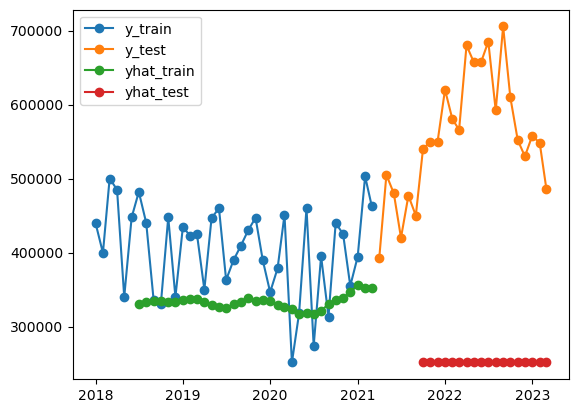

district_no 13
Epoch 1/20


2023-04-06 15:40:24.361562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:40:26.998825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:40:30.174043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:40:33.311382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:40:37.146122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:40:41.434321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:40:45.989465: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 120s 3s/step - loss: 0.0843
Epoch 2/20
33/33 [==============================] - 2s 67ms/step - loss: 0.0736
Epoch 3/20
33/33 [==============================] - 2s 48ms/step - loss: 0.0694
Epoch 4/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0728
Epoch 5/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0713
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0689
Epoch 7/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0683
Epoch 8/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0695
Epoch 9/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0670
Epoch 10/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0683
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0703
Epoch 12/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0677
Epoch 13/20
33/33 [=============================

2023-04-06 15:42:46.205849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:42:47.963165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:42:50.356074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:42:53.038994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 76602.91 RMSE
Test Score: 223126.43 RMSE


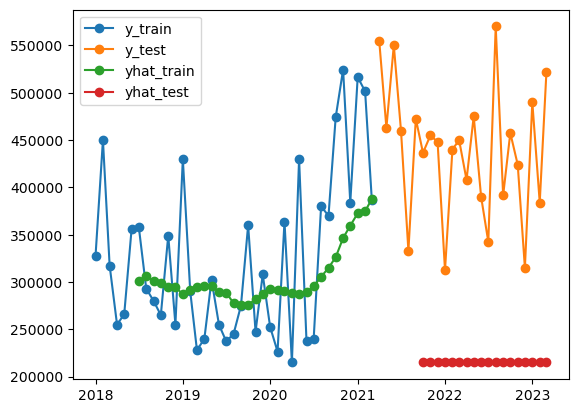

district_no 14
Epoch 1/20


2023-04-06 15:43:34.300317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:43:37.261504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:43:42.137693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:43:45.223323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:43:49.295358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:43:53.293445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:43:57.401499: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 122s 3s/step - loss: 0.0932
Epoch 2/20
33/33 [==============================] - 3s 73ms/step - loss: 0.0822
Epoch 3/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0825
Epoch 4/20
33/33 [==============================] - 2s 45ms/step - loss: 0.0821
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0817
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0815
Epoch 7/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0816
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0808
Epoch 9/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0811
Epoch 10/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0818
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0805
Epoch 12/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0814
Epoch 13/20
33/33 [=============================

2023-04-06 15:45:58.505587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:45:59.803910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:46:02.422841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:46:05.284053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 72220.85 RMSE
Test Score: 200349.75 RMSE


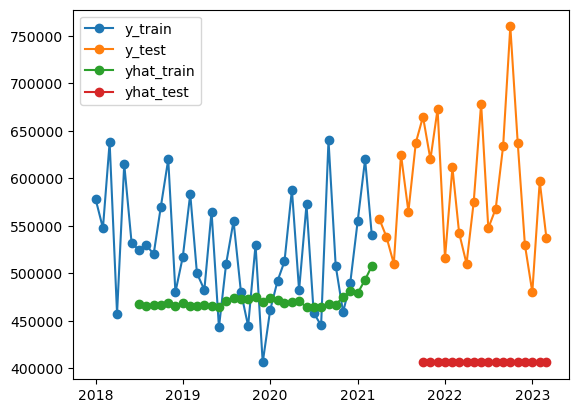

district_no 15
Epoch 1/20


2023-04-06 15:46:48.137465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:46:50.742063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:46:54.870154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:46:58.317422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:47:02.510809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:47:07.343461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:47:12.016599: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 126s 3s/step - loss: 0.1185
Epoch 2/20
33/33 [==============================] - 2s 58ms/step - loss: 0.1016
Epoch 3/20
33/33 [==============================] - 2s 48ms/step - loss: 0.0995
Epoch 4/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0993
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1001
Epoch 6/20
33/33 [==============================] - 2s 50ms/step - loss: 0.0995
Epoch 7/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0987
Epoch 8/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0992
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0981
Epoch 10/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0989
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0983
Epoch 12/20
33/33 [==============================] - 2s 45ms/step - loss: 0.0980
Epoch 13/20
33/33 [=============================

2023-04-06 15:49:15.883351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:49:17.189203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:49:19.399498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:49:21.165326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 34ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 60234.03 RMSE
Test Score: 166301.78 RMSE


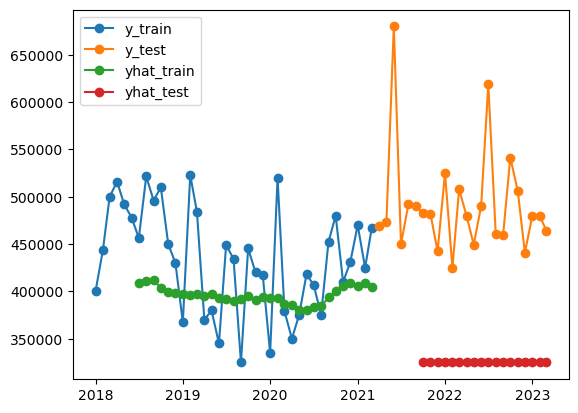

district_no 16
Epoch 1/20


2023-04-06 15:50:02.901499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:50:05.117405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:50:07.908119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:50:10.819733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:50:15.283859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:50:19.508396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:50:24.007410: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 107s 2s/step - loss: 0.1013
Epoch 2/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0800
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0769
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0756
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0796
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0751
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0746
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0749
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0737
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0740
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0775
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0748
Epoch 13/20
33/33 [=============================

2023-04-06 15:52:08.540137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:52:09.714862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:52:11.712875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:52:13.322745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 21526.89 RMSE
Test Score: 122154.39 RMSE


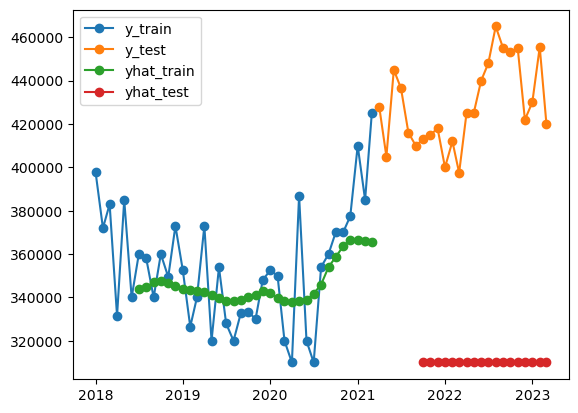

district_no 17
Epoch 1/20


2023-04-06 15:52:43.964353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:52:45.750952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:52:49.582481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:52:53.636233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:52:58.596481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:53:03.321755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:53:07.809602: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 144s 3s/step - loss: 0.1445
Epoch 2/20
33/33 [==============================] - 15s 470ms/step - loss: 0.1341
Epoch 3/20
33/33 [==============================] - 14s 429ms/step - loss: 0.1324
Epoch 4/20
33/33 [==============================] - 12s 358ms/step - loss: 0.1302
Epoch 5/20
33/33 [==============================] - 11s 345ms/step - loss: 0.1270
Epoch 6/20
33/33 [==============================] - 14s 423ms/step - loss: 0.1266
Epoch 7/20
33/33 [==============================] - 13s 397ms/step - loss: 0.1201
Epoch 8/20
33/33 [==============================] - 12s 370ms/step - loss: 0.1208
Epoch 9/20
33/33 [==============================] - 11s 343ms/step - loss: 0.1136
Epoch 10/20
33/33 [==============================] - 12s 360ms/step - loss: 0.1208
Epoch 11/20
33/33 [==============================] - 11s 349ms/step - loss: 0.1114
Epoch 12/20
33/33 [==============================] - 12s 355ms/step - loss: 0.1118
Epoch 13/20
33/33 [=======

2023-04-06 15:58:47.028364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:58:48.096726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:58:50.656474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:58:53.427993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 12s 561ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 138288.24 RMSE
Test Score: 246199.22 RMSE


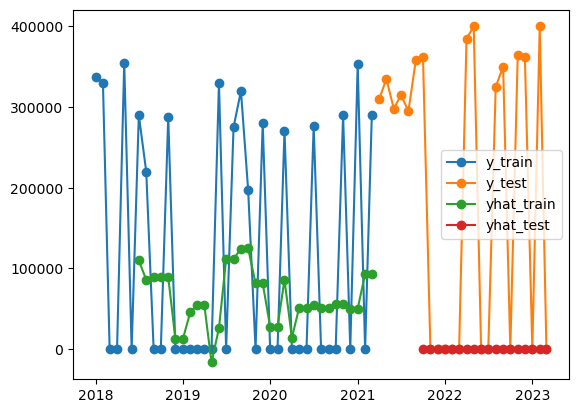

district_no 18
Epoch 1/20


2023-04-06 15:59:57.450202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 15:59:59.741197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:00:03.416382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:00:05.910921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:00:09.781409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:00:13.330862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:00:16.730923: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 107s 2s/step - loss: 0.1169
Epoch 2/20
33/33 [==============================] - 3s 79ms/step - loss: 0.1043
Epoch 3/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1021
Epoch 4/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1015
Epoch 5/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1008
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1010
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1024
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0991
Epoch 9/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0995
Epoch 10/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0999
Epoch 11/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0999
Epoch 12/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0992
Epoch 13/20
33/33 [=============================

2023-04-06 16:02:06.685054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:02:08.194249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:02:10.232630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:02:11.858803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 19ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 20655.82 RMSE
Test Score: 134166.01 RMSE


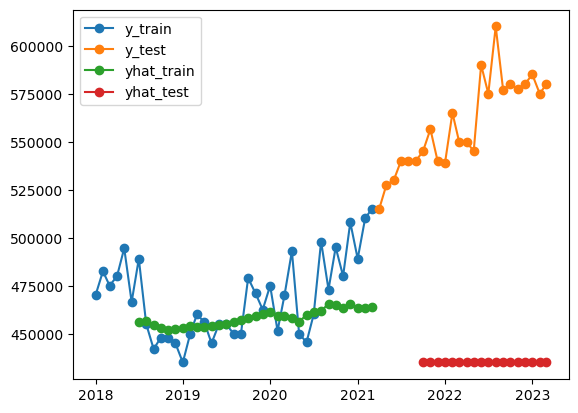

district_no 19
Epoch 1/20


2023-04-06 16:02:53.812829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:02:57.106048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:03:00.130432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:03:03.641253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:03:08.091390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:03:12.068654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:03:15.667256: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 103s 2s/step - loss: 0.1119
Epoch 2/20
33/33 [==============================] - 2s 52ms/step - loss: 0.0883
Epoch 3/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0870
Epoch 4/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0871
Epoch 5/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0867
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0852
Epoch 7/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0876
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0855
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0849
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0860
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0865
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0853
Epoch 13/20
33/33 [=============================

2023-04-06 16:04:58.209851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:04:59.504624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:05:01.646303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:05:04.042513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 38ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 13801.24 RMSE
Test Score: 127446.46 RMSE


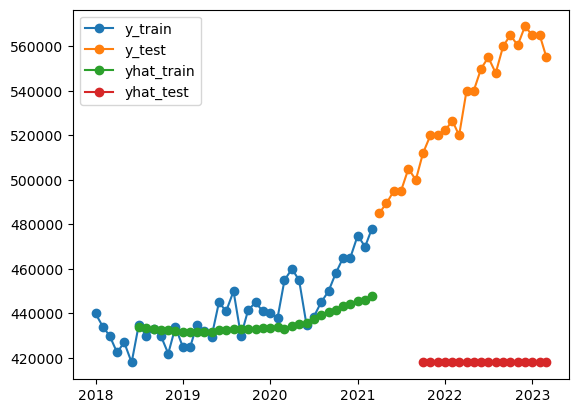

district_no 20
Epoch 1/20


2023-04-06 16:05:39.669984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:05:42.941672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:05:47.076660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:05:50.258209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:05:54.968081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:05:58.894753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:06:03.592134: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 108s 2s/step - loss: 0.1117
Epoch 2/20
33/33 [==============================] - 3s 92ms/step - loss: 0.0991
Epoch 3/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0976
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0970
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0969
Epoch 6/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0965
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0979
Epoch 8/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0963
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0967
Epoch 10/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0960
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0950
Epoch 12/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0945
Epoch 13/20
33/33 [=============================

2023-04-06 16:07:49.536998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:07:51.346840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:07:53.131406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:07:55.558745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 58ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 43355.38 RMSE
Test Score: 180012.60 RMSE


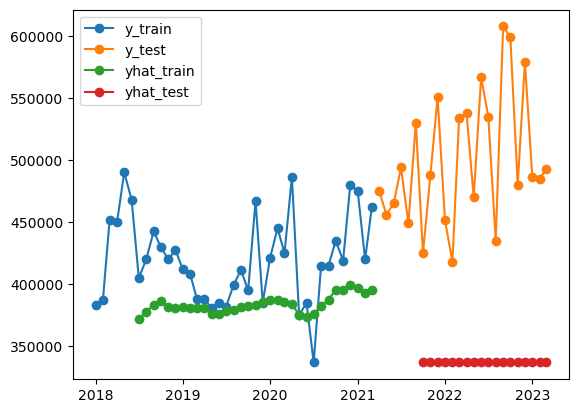

district_no 21
Epoch 1/20


2023-04-06 16:08:39.438527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:08:44.000839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:08:48.673909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:08:51.461879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:08:56.824947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:09:01.013116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:09:04.792573: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 138s 3s/step - loss: 0.1609
Epoch 2/20
33/33 [==============================] - 3s 87ms/step - loss: 0.1375
Epoch 3/20
33/33 [==============================] - 2s 64ms/step - loss: 0.1381
Epoch 4/20
33/33 [==============================] - 2s 49ms/step - loss: 0.1378
Epoch 5/20
33/33 [==============================] - 2s 49ms/step - loss: 0.1376
Epoch 6/20
33/33 [==============================] - 2s 51ms/step - loss: 0.1373
Epoch 7/20
33/33 [==============================] - 2s 57ms/step - loss: 0.1372
Epoch 8/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1387
Epoch 9/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1373
Epoch 10/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1388
Epoch 11/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1390
Epoch 12/20
33/33 [==============================] - 2s 60ms/step - loss: 0.1384
Epoch 13/20
33/33 [=============================

2023-04-06 16:11:23.978096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:11:25.173439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:11:27.405472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:11:29.504556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 41ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 267136.80 RMSE
Test Score: 532719.12 RMSE


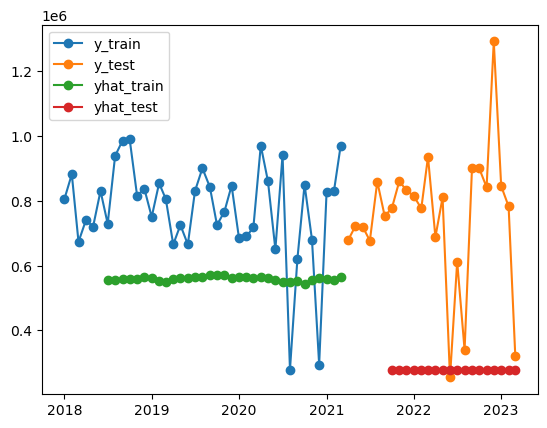

district_no 22
Epoch 1/20


2023-04-06 16:12:04.941016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:12:07.453484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:12:10.811281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:12:13.330297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:12:17.639522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:12:21.828455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:12:26.559990: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 125s 3s/step - loss: 0.1216
Epoch 2/20
33/33 [==============================] - 2s 50ms/step - loss: 0.0923
Epoch 3/20
33/33 [==============================] - 2s 45ms/step - loss: 0.0909
Epoch 4/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0907
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0917
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0900
Epoch 7/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0896
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0906
Epoch 9/20
33/33 [==============================] - 2s 53ms/step - loss: 0.0911
Epoch 10/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0901
Epoch 11/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0901
Epoch 12/20
33/33 [==============================] - 2s 49ms/step - loss: 0.0910
Epoch 13/20
33/33 [=============================

2023-04-06 16:14:45.593740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:14:47.512341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:14:50.200689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:14:52.983532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 17ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 22254.56 RMSE
Test Score: 124156.83 RMSE


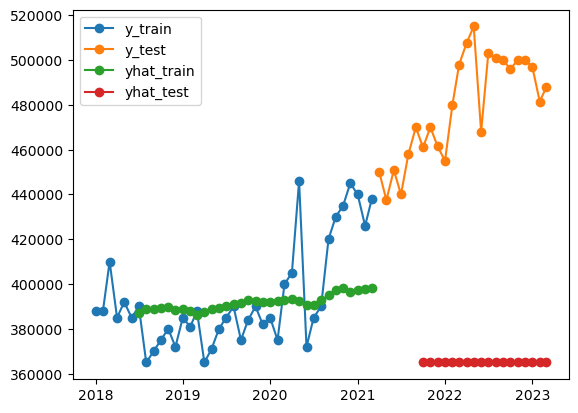

district_no 23
Epoch 1/20


2023-04-06 16:15:32.627434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:15:36.213437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:15:40.095651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:15:43.821072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:15:48.982344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:15:53.699959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:15:58.359390: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 130s 3s/step - loss: 0.1136
Epoch 2/20
33/33 [==============================] - 5s 128ms/step - loss: 0.1023
Epoch 3/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0993
Epoch 4/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0988
Epoch 5/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0985
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1008
Epoch 7/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1016
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0975
Epoch 9/20
33/33 [==============================] - 2s 46ms/step - loss: 0.1009
Epoch 10/20
33/33 [==============================] - 2s 50ms/step - loss: 0.0965
Epoch 11/20
33/33 [==============================] - 2s 50ms/step - loss: 0.0998
Epoch 12/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0982
Epoch 13/20
33/33 [============================

2023-04-06 16:18:13.298009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:18:14.524954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:18:17.241908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:18:20.036666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 47ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 24964.13 RMSE
Test Score: 159013.19 RMSE


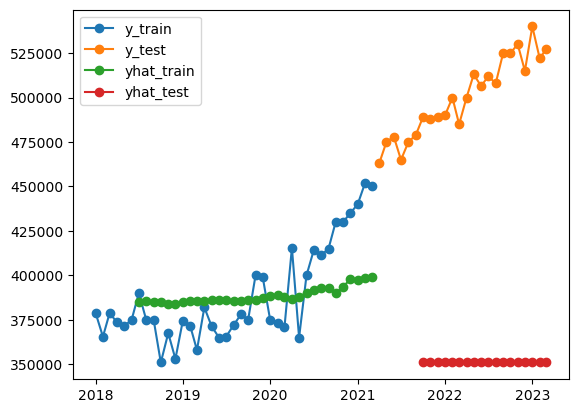

district_no 25
Epoch 1/20


2023-04-06 16:18:57.533363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:19:00.306151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:19:03.319093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:19:06.826172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:19:10.916721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:19:14.483847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:19:18.290838: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 108s 2s/step - loss: 0.1137
Epoch 2/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0942
Epoch 3/20
33/33 [==============================] - 2s 52ms/step - loss: 0.0944
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0944
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0944
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0948
Epoch 7/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0944
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0940
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0949
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0953
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0949
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0939
Epoch 13/20
33/33 [=============================

2023-04-06 16:21:09.931388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:21:11.546247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:21:13.639543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:21:16.288791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 17ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 24339.78 RMSE
Test Score: 164809.10 RMSE


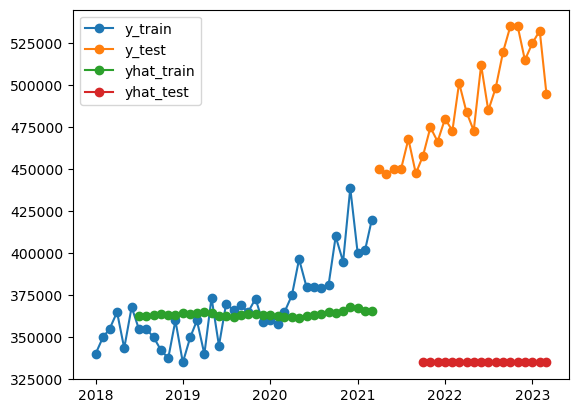

district_no 27
Epoch 1/20


2023-04-06 16:21:54.049100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:21:56.390694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:22:00.670991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:22:03.982504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:22:08.712732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:22:12.277265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:22:16.962984: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 106s 2s/step - loss: 0.1499
Epoch 2/20
33/33 [==============================] - 3s 91ms/step - loss: 0.1322
Epoch 3/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1318
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1343
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1314
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1337
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1303
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1293
Epoch 9/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1296
Epoch 10/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1293
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1305
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1292
Epoch 13/20
33/33 [=============================

2023-04-06 16:24:05.954422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:24:07.476965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:24:09.215605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:24:10.944070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 22ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 23561.42 RMSE
Test Score: 146544.76 RMSE


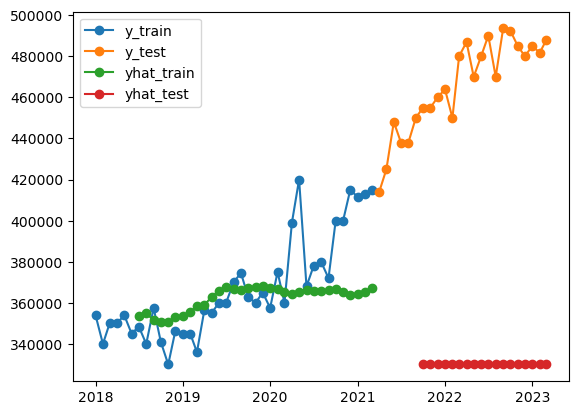

district_no 28
Epoch 1/20


2023-04-06 16:24:49.455918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:24:51.537832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:24:54.366402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:24:57.132204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:25:00.982840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:25:04.971940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:25:08.718077: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 106s 2s/step - loss: 0.1141
Epoch 2/20
33/33 [==============================] - 3s 68ms/step - loss: 0.0974
Epoch 3/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0992
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0962
Epoch 5/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0956
Epoch 6/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0959
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0955
Epoch 8/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0945
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0945
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0951
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0963
Epoch 12/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0938
Epoch 13/20
33/33 [=============================

2023-04-06 16:27:02.011473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:27:03.292455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:27:05.523872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:27:07.712512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 24ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 16971.35 RMSE
Test Score: 131064.18 RMSE


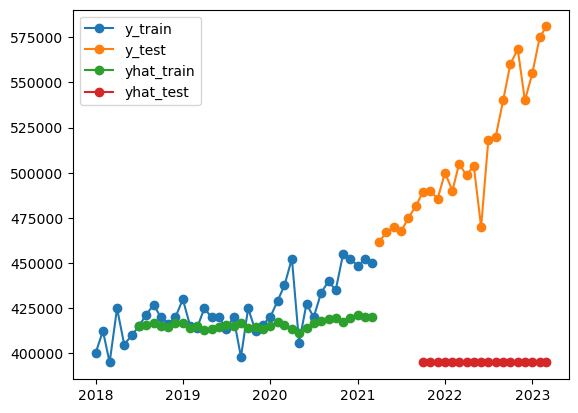

In [80]:
# run the model for all districts
district_no_list = list(train_lstm_df_dict.keys())
test_score_dict = {}
for district_no in district_no_list:
    print("district_no", district_no)
    model = fit_lstm(train_lstm_dataset_dict[district_no])
    test_score = evaluate_lstm(
        model=model,
        X_train=train_lstm_dataset_dict[district_no],
        X_test=test_lstm_dataset_dict[district_no],
        district_no=district_no,
        lookback=lookback,
    )           
    test_score_dict[district_no] = test_score       

In [81]:
test_score_dict

{1: 452249.18831694254,
 2: 942151.447460545,
 3: 187180.71654479322,
 4: 270948.2255864475,
 5: 244527.71940120726,
 7: 478284.91573119885,
 8: 572042.3544482233,
 10: 275993.260684226,
 11: None,
 12: 346430.9018112815,
 13: 223126.4277887713,
 14: 200349.74969898126,
 15: 166301.78306190658,
 16: 122154.38774126963,
 17: 246199.21737949896,
 18: 134166.00738554375,
 19: 127446.458078154,
 20: 180012.6032970408,
 21: 532719.1249721668,
 22: 124156.82760480347,
 23: 159013.18952981368,
 25: 164809.1000049586,
 27: 146544.76452606556,
 28: 131064.1789930075}

# LSTM Model with linear interpolation

district_no 1 linear interpolation applied
Epoch 1/20


2023-04-06 16:27:48.185562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:27:50.764110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:27:53.301233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:27:56.430477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:28:01.396195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:28:05.020449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:28:09.700908: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 108s 2s/step - loss: 0.0897
Epoch 2/20
33/33 [==============================] - 2s 60ms/step - loss: 0.0760
Epoch 3/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0738
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0763
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0738
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0772
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0733
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0735
Epoch 9/20
33/33 [==============================] - 2s 50ms/step - loss: 0.0749
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0728
Epoch 11/20
33/33 [==============================] - 1s 40ms/step - loss: 0.0725
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0723
Epoch 13/20
33/33 [=============================

2023-04-06 16:30:00.895003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:30:02.086316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:30:04.121464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:30:06.152979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 20s 797ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 59036.28 RMSE
Test Score: 149832.67 RMSE


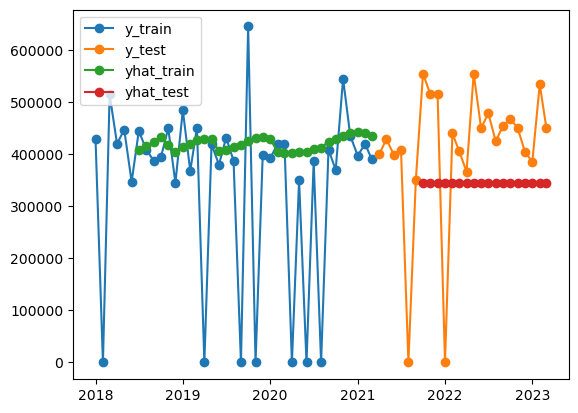

district_no 2 linear interpolation applied
Epoch 1/20


2023-04-06 16:30:57.673234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:30:59.752539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:31:02.351734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:31:05.164259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:31:09.103729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:31:13.291553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:31:17.624166: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 96s 2s/step - loss: 0.1396
Epoch 2/20
33/33 [==============================] - 2s 64ms/step - loss: 0.1185
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1172
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1152
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1158
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1167
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1147
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1138
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1140
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1162
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1142
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1169
Epoch 13/20
33/33 [==============================

2023-04-06 16:32:58.381319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:32:59.839459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:33:01.909835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:33:03.933984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 41ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 173963.87 RMSE
Test Score: 481880.60 RMSE


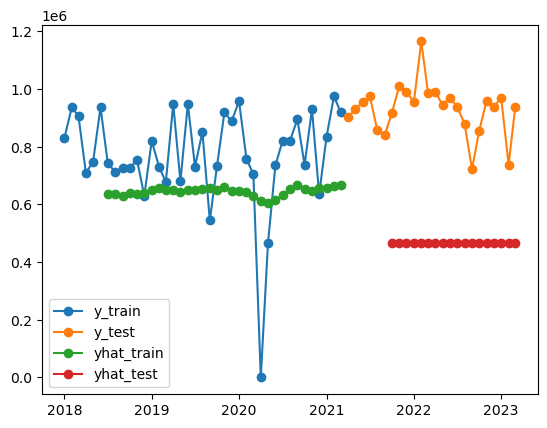

district_no 3 linear interpolation applied
Epoch 1/20


2023-04-06 16:33:40.336105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:33:42.210889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:33:44.823004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:33:47.749126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:33:51.498271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:33:55.092913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:33:58.571218: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 93s 2s/step - loss: 0.1187
Epoch 2/20
33/33 [==============================] - 2s 54ms/step - loss: 0.0958
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0931
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0921
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0947
Epoch 6/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0938
Epoch 7/20
33/33 [==============================] - 2s 61ms/step - loss: 0.0937
Epoch 8/20
33/33 [==============================] - 2s 54ms/step - loss: 0.0930
Epoch 9/20
33/33 [==============================] - 2s 73ms/step - loss: 0.0932
Epoch 10/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0919
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0921
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0937
Epoch 13/20
33/33 [==============================

2023-04-06 16:35:37.195439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:35:38.342659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:35:40.459232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:35:42.710151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 21ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 64499.71 RMSE
Test Score: 187180.72 RMSE


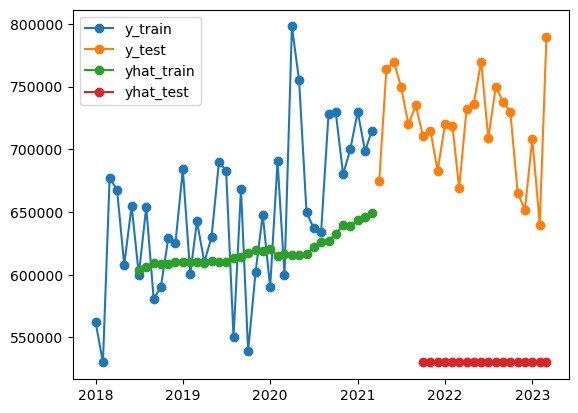

district_no 4 linear interpolation applied
Epoch 1/20


2023-04-06 16:36:10.713820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:36:13.068321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:36:15.774552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:36:18.044028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:36:21.869393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:36:25.206684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:36:28.299235: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 87s 2s/step - loss: 0.0907
Epoch 2/20
33/33 [==============================] - 2s 53ms/step - loss: 0.0797
Epoch 3/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0803
Epoch 4/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0798
Epoch 5/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0799
Epoch 6/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0795
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0794
Epoch 8/20
33/33 [==============================] - 2s 49ms/step - loss: 0.0787
Epoch 9/20
33/33 [==============================] - 2s 49ms/step - loss: 0.0794
Epoch 10/20
33/33 [==============================] - 2s 51ms/step - loss: 0.0802
Epoch 11/20
33/33 [==============================] - 2s 48ms/step - loss: 0.0789
Epoch 12/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0806
Epoch 13/20
33/33 [==============================

2023-04-06 16:38:01.797552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:38:03.409301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:38:05.489017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:38:07.933928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 38ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 87707.59 RMSE
Test Score: 270948.23 RMSE


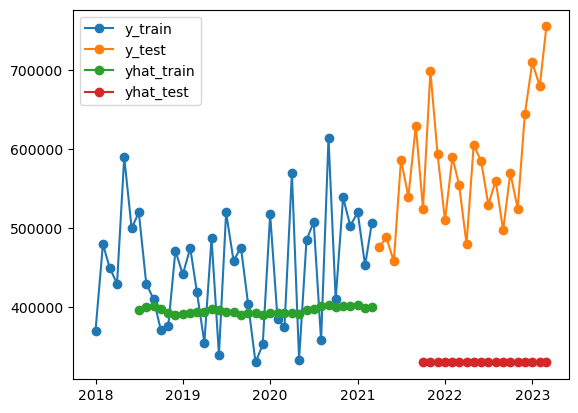

district_no 5 linear interpolation applied
Epoch 1/20


2023-04-06 16:38:52.341103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:38:55.125643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:38:57.971039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:39:00.758818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:39:04.919222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:39:08.820819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:39:12.421202: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 117s 3s/step - loss: 0.1149
Epoch 2/20
33/33 [==============================] - 3s 103ms/step - loss: 0.1007
Epoch 3/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0995
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1019
Epoch 5/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0963
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0985
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0960
Epoch 8/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0951
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0951
Epoch 10/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0946
Epoch 11/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0939
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0945
Epoch 13/20
33/33 [============================

2023-04-06 16:41:13.257935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:41:14.845116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:41:17.018898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:41:19.180556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 71543.02 RMSE
Test Score: 244527.72 RMSE


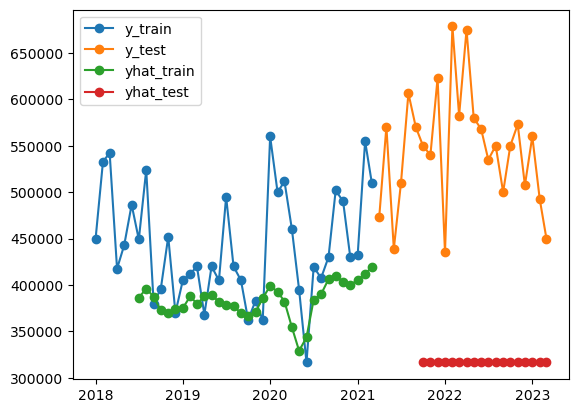

district_no 7 linear interpolation applied
Epoch 1/20


2023-04-06 16:41:59.224234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:42:02.183134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:42:05.219941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:42:09.119381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:42:13.152889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:42:17.482424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:42:22.284462: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 136s 3s/step - loss: 0.1040
Epoch 2/20
33/33 [==============================] - 4s 136ms/step - loss: 0.0895
Epoch 3/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0896
Epoch 4/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0905
Epoch 5/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0901
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0896
Epoch 7/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0895
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0900
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0891
Epoch 10/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0886
Epoch 11/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0899
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0898
Epoch 13/20
33/33 [============================

2023-04-06 16:44:40.006896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:44:41.180232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:44:43.340957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:44:45.942815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 60ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 49388.92 RMSE
Test Score: 188147.55 RMSE


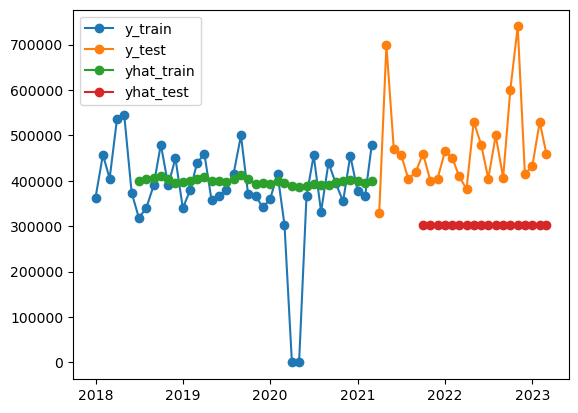

district_no 8 linear interpolation applied
Epoch 1/20


2023-04-06 16:45:26.509207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:45:28.849035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:45:32.230262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:45:35.086788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:45:40.085302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:45:44.051942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:45:48.667316: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 127s 3s/step - loss: 0.1021
Epoch 2/20
33/33 [==============================] - 2s 71ms/step - loss: 0.0897
Epoch 3/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0897
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0870
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0876
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0875
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0863
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0862
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0879
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0860
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0863
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0861
Epoch 13/20
33/33 [=============================

2023-04-06 16:47:54.592635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:47:55.762538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:47:58.189147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:48:00.405491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 65689.06 RMSE
Test Score: 187852.82 RMSE


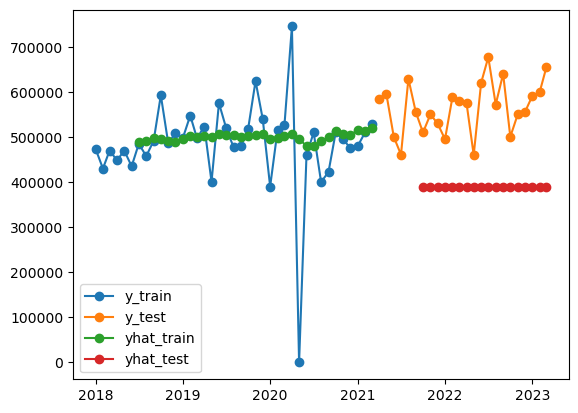

district_no 10 linear interpolation applied
Epoch 1/20


2023-04-06 16:48:38.253765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:48:40.540306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:48:43.034800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:48:45.404094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:48:49.406449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:48:53.017310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:48:57.285875: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 122s 3s/step - loss: 0.0701
Epoch 2/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0659
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0647
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0645
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0630
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0642
Epoch 7/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0636
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0642
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0642
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0630
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0632
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0635
Epoch 13/20
33/33 [=============================

2023-04-06 16:51:00.766356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:51:02.005144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:51:04.158566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:51:06.745971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 60662.33 RMSE
Test Score: 275993.26 RMSE


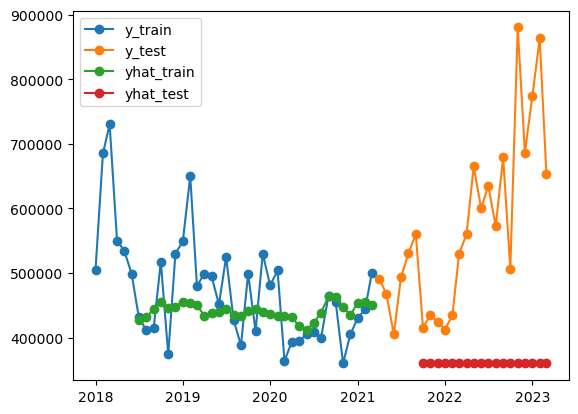

district_no 11 linear interpolation applied
Epoch 1/20


2023-04-06 16:51:46.303458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:51:48.955299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:51:51.716110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:51:54.599421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:52:00.184971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:52:05.027656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:52:08.835630: I tensorflow/core/grappler/optimizers/cust

21/21 [==============================] - 115s 4s/step - loss: nan
Epoch 2/20
21/21 [==============================] - 8s 359ms/step - loss: nan
Epoch 3/20
21/21 [==============================] - 1s 44ms/step - loss: nan
Epoch 4/20
21/21 [==============================] - 1s 44ms/step - loss: nan
Epoch 5/20
21/21 [==============================] - 1s 42ms/step - loss: nan
Epoch 6/20
21/21 [==============================] - 1s 43ms/step - loss: nan
Epoch 7/20
21/21 [==============================] - 1s 42ms/step - loss: nan
Epoch 8/20
21/21 [==============================] - 1s 42ms/step - loss: nan
Epoch 9/20
21/21 [==============================] - 1s 43ms/step - loss: nan
Epoch 10/20
21/21 [==============================] - 1s 45ms/step - loss: nan
Epoch 11/20
21/21 [==============================] - 1s 42ms/step - loss: nan
Epoch 12/20
21/21 [==============================] - 1s 43ms/step - loss: nan
Epoch 13/20
21/21 [==============================] - 1s 43ms/step - loss: nan
Epoch

2023-04-06 16:53:58.283980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:53:59.464941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:54:03.161599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:54:05.469766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 27s 1s/step
yhat train shape (21, 10)
yhat test shape (18, 10)
y train shape (21,)
y test shape (18,)
model for district 11 cannot be evaluated
district_no 12 linear interpolation applied
Epoch 1/20


2023-04-06 16:55:09.207343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:55:11.553025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:55:15.324764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:55:19.022762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:55:25.310995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:55:29.543092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:55:34.257378: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 124s 3s/step - loss: 0.1159
Epoch 2/20
33/33 [==============================] - 2s 60ms/step - loss: 0.0962
Epoch 3/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0945
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1019
Epoch 5/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0916
Epoch 6/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0919
Epoch 7/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0938
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0931
Epoch 9/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0922
Epoch 10/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0914
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0903
Epoch 12/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0922
Epoch 13/20
33/33 [=============================

2023-04-06 16:57:35.937236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:57:37.502177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:57:39.930582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:57:41.770689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 26ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 80103.88 RMSE
Test Score: 346430.90 RMSE


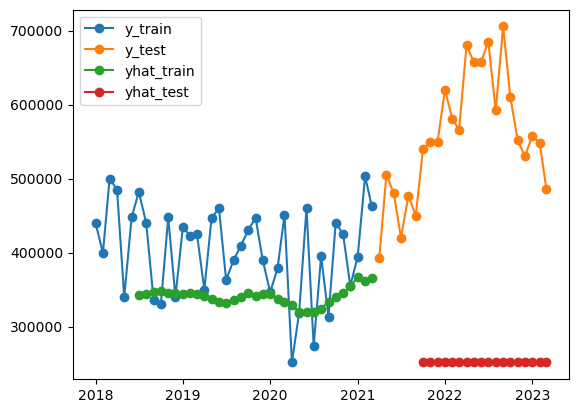

district_no 13 linear interpolation applied
Epoch 1/20


2023-04-06 16:58:23.051639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:58:26.218706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:58:29.343680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:58:32.538072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:58:37.533987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:58:42.325061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 16:58:46.862712: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 134s 3s/step - loss: 0.0837
Epoch 2/20
33/33 [==============================] - 3s 82ms/step - loss: 0.0709
Epoch 3/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0688
Epoch 4/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0704
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0681
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0678
Epoch 7/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0695
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0670
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0670
Epoch 10/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0670
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0682
Epoch 12/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0678
Epoch 13/20
33/33 [=============================

2023-04-06 17:00:59.118307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:01:00.384403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:01:02.170736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:01:04.292141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 89900.57 RMSE
Test Score: 223126.43 RMSE


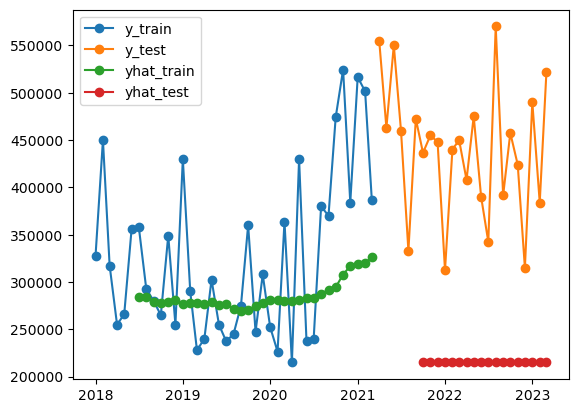

district_no 14 linear interpolation applied
Epoch 1/20


2023-04-06 17:01:30.922382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:01:32.593314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:01:35.316687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:01:37.628801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:01:41.165597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:01:44.336058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:01:47.612441: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 78s 2s/step - loss: 0.0960
Epoch 2/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0862
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0836
Epoch 4/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0812
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0823
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0812
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0808
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0817
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0814
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0809
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0815
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0820
Epoch 13/20
33/33 [==============================

2023-04-06 17:03:18.000474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:03:19.171456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:03:21.818555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:03:23.657372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 28ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 64351.61 RMSE
Test Score: 200349.75 RMSE


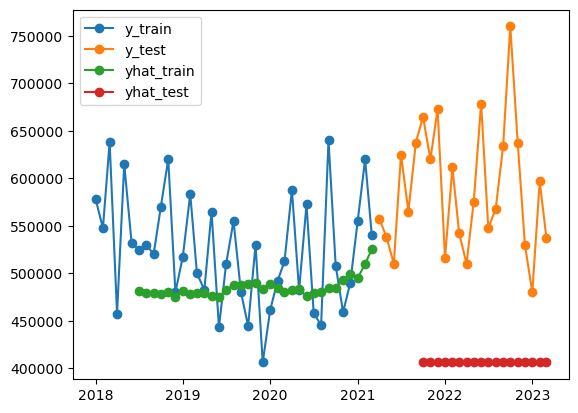

district_no 15 linear interpolation applied
Epoch 1/20


2023-04-06 17:03:54.193862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:03:56.437437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:04:00.153634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:04:03.437237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:04:07.760551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:04:11.255228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:04:15.292986: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 103s 2s/step - loss: 0.1115
Epoch 2/20
33/33 [==============================] - 2s 53ms/step - loss: 0.1004
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1016
Epoch 4/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1008
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0989
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1028
Epoch 7/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1000
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0997
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0978
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1012
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0974
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0976
Epoch 13/20
33/33 [=============================

2023-04-06 17:06:04.868766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:06:06.101697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:06:07.975996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:06:10.666326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 41ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 63778.80 RMSE
Test Score: 166301.78 RMSE


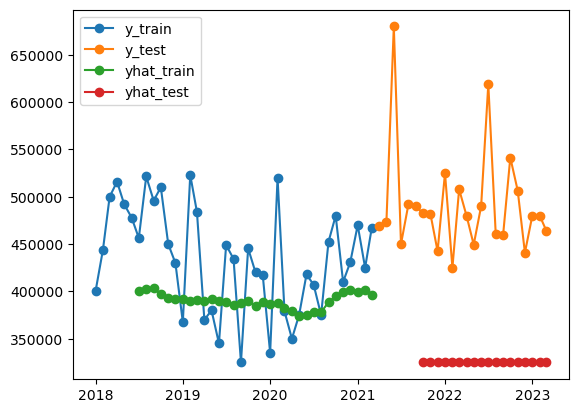

district_no 16 linear interpolation applied
Epoch 1/20


2023-04-06 17:06:50.314483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:06:52.627171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:06:55.794834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:06:58.958954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:07:05.248301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:07:10.286495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:07:14.908055: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 113s 3s/step - loss: 0.1008
Epoch 2/20
33/33 [==============================] - 4s 126ms/step - loss: 0.0810
Epoch 3/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0799
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0784
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0754
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0765
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0747
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0759
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0744
Epoch 10/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0753
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0738
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0741
Epoch 13/20
33/33 [============================

2023-04-06 17:09:14.062246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:09:15.675792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:09:18.409332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:09:22.195287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 39ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 21858.34 RMSE
Test Score: 122154.39 RMSE


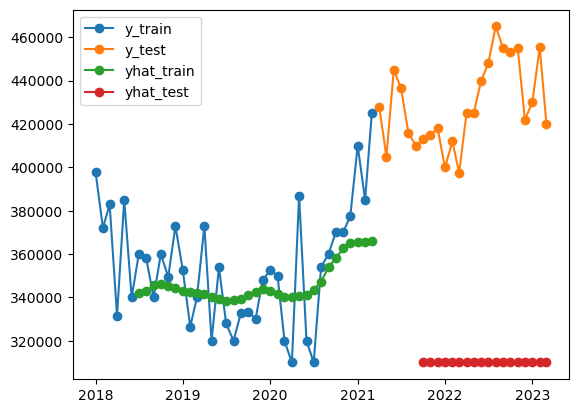

district_no 17 linear interpolation applied
Epoch 1/20


2023-04-06 17:09:56.874577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:09:59.283973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:10:02.671877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:10:06.524954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:10:10.700620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:10:14.539588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:10:20.046936: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 132s 3s/step - loss: 0.0834
Epoch 2/20
33/33 [==============================] - 5s 152ms/step - loss: 0.0727
Epoch 3/20
33/33 [==============================] - 2s 45ms/step - loss: 0.0722
Epoch 4/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0711
Epoch 5/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0703
Epoch 6/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0700
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0696
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0693
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0695
Epoch 10/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0699
Epoch 11/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0699
Epoch 12/20
33/33 [==============================] - 2s 51ms/step - loss: 0.0696
Epoch 13/20
33/33 [============================

2023-04-06 17:12:40.397392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:12:42.449816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:12:45.644707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:12:48.602686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 25s 1s/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 66612.15 RMSE
Test Score: 186879.82 RMSE


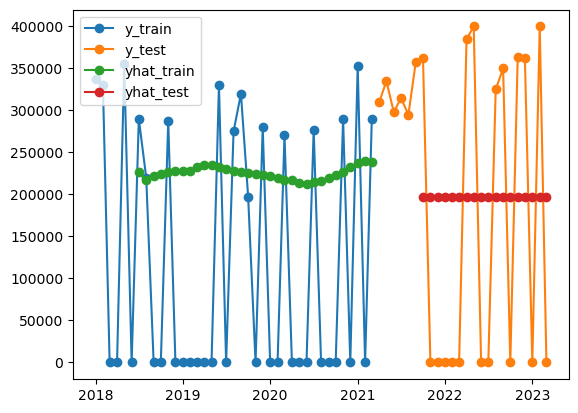

district_no 18 linear interpolation applied
Epoch 1/20


2023-04-06 17:13:52.447007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:13:55.133636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:14:00.796348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:14:03.620371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:14:09.168812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:14:13.095413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:14:17.403146: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 130s 3s/step - loss: 0.1242
Epoch 2/20
33/33 [==============================] - 2s 66ms/step - loss: 0.1032
Epoch 3/20
33/33 [==============================] - 2s 46ms/step - loss: 0.1016
Epoch 4/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1021
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1028
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1028
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1019
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0997
Epoch 9/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0993
Epoch 10/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1003
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0996
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0980
Epoch 13/20
33/33 [=============================

2023-04-06 17:16:28.064672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:16:29.712218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:16:36.678360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:16:38.900318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 38ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 19601.90 RMSE
Test Score: 134166.01 RMSE


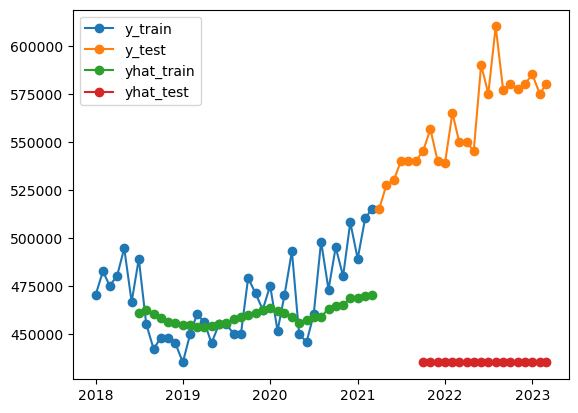

district_no 19 linear interpolation applied
Epoch 1/20


2023-04-06 17:17:37.334357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:17:40.597465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:17:45.095838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:17:48.160380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:17:53.911209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:17:58.865075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:18:02.917069: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 136s 3s/step - loss: 0.1145
Epoch 2/20
33/33 [==============================] - 3s 80ms/step - loss: 0.0882
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0864
Epoch 4/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0865
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0869
Epoch 6/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0859
Epoch 7/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0856
Epoch 8/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0859
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0865
Epoch 10/20
33/33 [==============================] - 2s 49ms/step - loss: 0.0865
Epoch 11/20
33/33 [==============================] - 2s 58ms/step - loss: 0.0851
Epoch 12/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0861
Epoch 13/20
33/33 [=============================

2023-04-06 17:20:21.139549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:20:22.438828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:20:24.888385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:20:27.661534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 2s 71ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 14482.00 RMSE
Test Score: 127446.46 RMSE


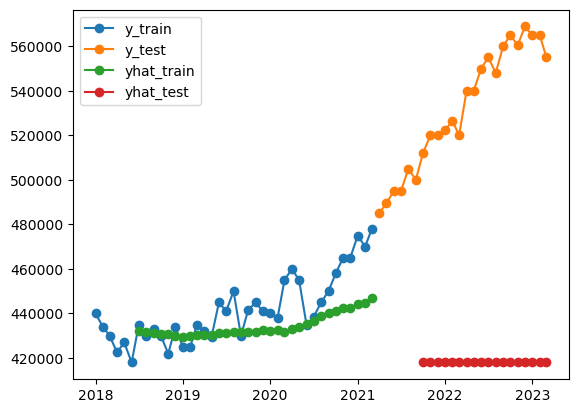

district_no 20 linear interpolation applied
Epoch 1/20


2023-04-06 17:21:14.143141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:21:17.458566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:21:21.692969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:21:25.766757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:21:32.247460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:21:37.247773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:21:42.031680: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 144s 3s/step - loss: 0.1155
Epoch 2/20
33/33 [==============================] - 5s 134ms/step - loss: 0.0974
Epoch 3/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0992
Epoch 4/20
33/33 [==============================] - 2s 59ms/step - loss: 0.0978
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0955
Epoch 6/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0972
Epoch 7/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0963
Epoch 8/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0962
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0976
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0958
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0951
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0949
Epoch 13/20
33/33 [============================

2023-04-06 17:24:06.916948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:24:08.668956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:24:11.388637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:24:14.123425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 51ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 40019.83 RMSE
Test Score: 180012.60 RMSE


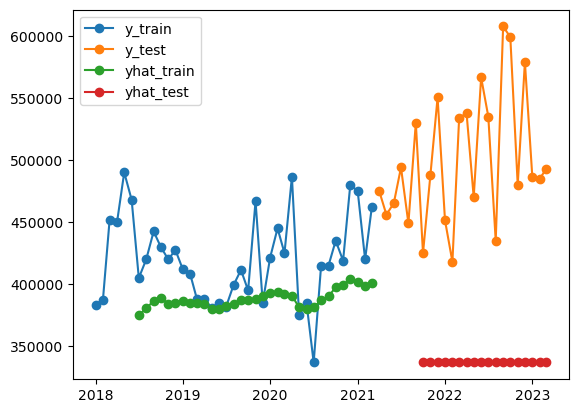

district_no 21 linear interpolation applied
Epoch 1/20


2023-04-06 17:25:01.001753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:25:03.938618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:25:07.879592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:25:11.702252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:25:16.892936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:25:21.629440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:25:28.375533: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 149s 4s/step - loss: 0.1597
Epoch 2/20
33/33 [==============================] - 5s 138ms/step - loss: 0.1374
Epoch 3/20
33/33 [==============================] - 2s 51ms/step - loss: 0.1377
Epoch 4/20
33/33 [==============================] - 2s 49ms/step - loss: 0.1395
Epoch 5/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1392
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1379
Epoch 7/20
33/33 [==============================] - 2s 47ms/step - loss: 0.1374
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1396
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1402
Epoch 10/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1397
Epoch 11/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1405
Epoch 12/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1371
Epoch 13/20
33/33 [============================

2023-04-06 17:27:58.365133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:28:00.343361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:28:02.394815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:28:06.800706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 23ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 284382.73 RMSE
Test Score: 532719.12 RMSE


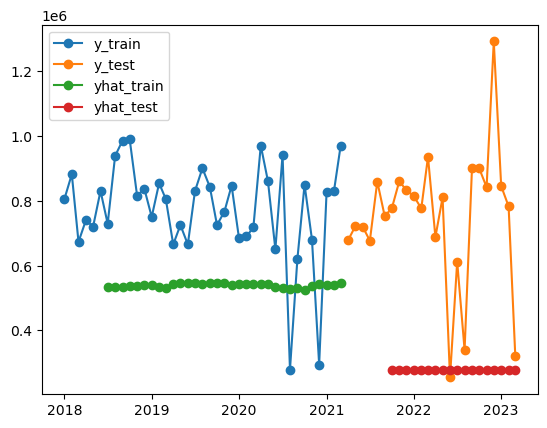

district_no 22 linear interpolation applied
Epoch 1/20


2023-04-06 17:28:56.082032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:28:59.718593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:29:03.343601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:29:06.492351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:29:11.572334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:29:15.633691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:29:20.280300: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 149s 3s/step - loss: 0.1174
Epoch 2/20
33/33 [==============================] - 4s 124ms/step - loss: 0.0944
Epoch 3/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0916
Epoch 4/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0948
Epoch 5/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0914
Epoch 6/20
33/33 [==============================] - 2s 45ms/step - loss: 0.0906
Epoch 7/20
33/33 [==============================] - 2s 53ms/step - loss: 0.0896
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0897
Epoch 9/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0894
Epoch 10/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0903
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0927
Epoch 12/20
33/33 [==============================] - 2s 50ms/step - loss: 0.0898
Epoch 13/20
33/33 [============================

2023-04-06 17:31:49.365459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:31:51.044303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:31:53.771309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:31:56.120875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 48ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 21441.97 RMSE
Test Score: 124156.83 RMSE


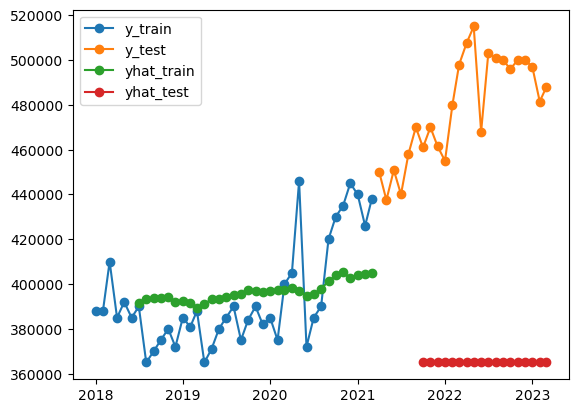

district_no 23 linear interpolation applied
Epoch 1/20


2023-04-06 17:32:48.167873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:32:51.391654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:32:56.026592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:32:59.246587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:33:14.865103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:33:20.042694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:33:25.217155: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 174s 4s/step - loss: 0.1271
Epoch 2/20
33/33 [==============================] - 2s 67ms/step - loss: 0.0996
Epoch 3/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1022
Epoch 4/20
33/33 [==============================] - 2s 53ms/step - loss: 0.0983
Epoch 5/20
33/33 [==============================] - 2s 56ms/step - loss: 0.1019
Epoch 6/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0974
Epoch 7/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0988
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0974
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0974
Epoch 10/20
33/33 [==============================] - 2s 46ms/step - loss: 0.1013
Epoch 11/20
33/33 [==============================] - 2s 48ms/step - loss: 0.0977
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0954
Epoch 13/20
33/33 [=============================

2023-04-06 17:36:04.800271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:36:06.706389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:36:09.956079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:36:13.067149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 22ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 25193.95 RMSE
Test Score: 159013.19 RMSE


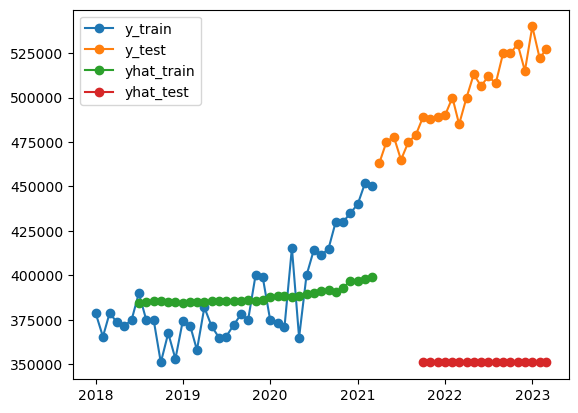

district_no 25 linear interpolation applied
Epoch 1/20


2023-04-06 17:37:12.809142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:37:15.521273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:37:19.160692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:37:23.747763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:37:31.291746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:37:36.868114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:37:43.606238: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 172s 4s/step - loss: 0.1056
Epoch 2/20
33/33 [==============================] - 2s 64ms/step - loss: 0.0953
Epoch 3/20
33/33 [==============================] - 2s 49ms/step - loss: 0.0948
Epoch 4/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0951
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0956
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0941
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0949
Epoch 8/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0951
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0952
Epoch 10/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0944
Epoch 11/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0942
Epoch 12/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0946
Epoch 13/20
33/33 [=============================

2023-04-06 17:40:21.808388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:40:23.331673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:40:26.502806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:40:29.157451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 47ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 25504.85 RMSE
Test Score: 164809.10 RMSE


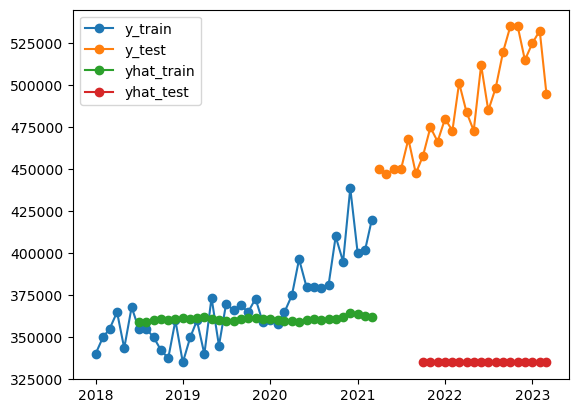

district_no 27 linear interpolation applied
Epoch 1/20


2023-04-06 17:41:28.462187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:41:31.778694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:41:44.804304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:41:48.823554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 17:41:53.977149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [82]:
def fit_lstm_L(train):
    model = Sequential()
    model.add( 
        Masking(
            mask_value=0.,
            input_shape=(
                lookback,
                num_features,
            ),
        )
    ) # mask the 0 values
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer="adam")
    model.fit(
        train,
        epochs=20,
        batch_size=8, 
        verbose=1 # type: ignore
    )

    return model

def evaluate_lstm_L(model, X_train, X_test, district_no, lookback):
    # make predictions
    yhat_train = model.predict(X_train)
    yhat_test = model.predict(X_test)

    # pad the predictions
    yhat_train_padded = np.zeros((len(yhat_train), num_features))
    yhat_train_padded[:, 0] = yhat_train[:, 0]
    yhat_test_padded = np.zeros((len(yhat_test), num_features))
    yhat_test_padded[:, 0] = yhat_test_padded[:, 0]
    
    # inverse transform the predictions
    yhat_train_inversed = scaler_dict_L[district_no].inverse_transform(yhat_train_padded)
    yhat_test_inversed = scaler_dict_L[district_no].inverse_transform(yhat_test_padded)
    print("yhat train shape", yhat_train_inversed.shape)
    print("yhat test shape", yhat_test_inversed.shape)

    # take values only
    yhat_train_inversed = yhat_train_inversed[:, 0] 
    yhat_test_inversed = yhat_test_inversed[:, 0]

    # ground truth
    y_train = train_lstm_df_dict_L[district_no]['resale_price'].values[lookback:] # remove the first lookback months
    y_test = test_lstm_df_dict[district_no]['resale_price'].values[lookback:] # remove the first lookback months
    print("y train shape", y_train.shape)
    print("y test shape", y_test.shape)

    try:
        train_score = math.sqrt(mean_squared_error(y_train, yhat_train_inversed))
        print('Train Score: %.2f RMSE' % (train_score))
        test_score = math.sqrt(mean_squared_error(y_test, yhat_test_inversed))
        print('Test Score: %.2f RMSE' % (test_score))
    except ValueError:
        print(f'model for district {district_no} cannot be evaluated')
        return None

    try: 
        # set index of the predictions 
        yhat_train_df = pd.DataFrame(yhat_train_inversed, index=train_lstm_df_dict[1].index[lookback:])
        yhat_test_df = pd.DataFrame(yhat_test_inversed, index=test_lstm_df_dict[1].index[lookback:])
    except ValueError:
        print(f'model for district {district_no} cannot be evaluated')
        return None

    # plot baseline and predictions
    plt.plot(train_lstm_df_dict[district_no]['resale_price'], label="y_train", marker='o')
    plt.plot(test_lstm_df_dict[district_no]['resale_price'], label="y_test", marker='o')
    plt.plot(yhat_train_df, label="yhat_train", marker='o')
    plt.plot(yhat_test_df, label="yhat_test", marker='o')
    plt.legend()
    plt.show()

    return test_score

# run the model for all districts with linear interpolation applied to the missing values
district_no_list = list(train_lstm_df_dict_L.keys())
test_score_dict_LI = {}

for district_no in district_no_list:
    print("district_no", district_no, "linear interpolation applied")
    model = fit_lstm_L(train_lstm_dataset_dict_L[district_no])
    test_score = evaluate_lstm_L(
        model=model,
        X_train=train_lstm_dataset_dict_L[district_no],
        X_test=test_lstm_dataset_dict[district_no],
        district_no=district_no,
        lookback=lookback,
    )           
    test_score_dict_LI[district_no] = test_score 

# Evaluation

In [ ]:
evaluations_df = pd.read_csv("eval/SARIMA_SARIMAX_evaluations.csv", index_col=0)

evaluations_df["LSTM"] = pd.Series(test_score_dict)
evaluations_df["LSTM_LI"] = pd.Series(test_score_dict_LI)

# drop best model column
evaluations_df.drop(columns=["Best Model"], inplace=True)

def model_comparator(row):
    return row.index[row.values == row.min()].to_list()

evaluations_df["best_model"] = evaluations_df.apply(model_comparator, axis=1)
evaluations_df['best_model'] = evaluations_df['best_model'].apply(lambda x: ["RMSE_Baseline"] if "RMSE_Baseline" in x else x)


# Poor performance of LSTM

In [ ]:
evaluations_df


,RMSE_SARIMAX,RMSE_SARIMAX_L,RMSE_SARIMA,RMSE_SARIMA_L,RMSE_Baseline,LSTM,LSTM_LI,best_model
1,1.725116e+05,8.092334e+04,8.092334e+04,8.092334e+04,80923.339144,452249.188317,149832.667778,[RMSE_Baseline]
2,1.653056e+05,1.698050e+05,1.653056e+05,1.698050e+05,87935.362860,942151.447461,481880.597194,[RMSE_Baseline]
3,3.882617e+04,3.882617e+04,3.882617e+04,3.882617e+04,38424.434301,187180.716545,187180.716545,[RMSE_Baseline]
4,1.126580e+05,1.126580e+05,1.126580e+05,1.126580e+05,103630.484743,270948.225586,270948.225586,[RMSE_Baseline]
5,7.284013e+04,7.284013e+04,7.284013e+04,7.284013e+04,72840.126460,244527.719401,244527.719401,[RMSE_Baseline]
7,1.151819e+05,1.172143e+05,1.151819e+05,1.172143e+05,94444.824771,478284.915731,188147.553663,[RMSE_Baseline]
8,7.766312e+04,7.320619e+04,7.766312e+04,7.320619e+04,68113.848543,572042.354448,187852.819913,[RMSE_Baseline]
10,7.981001e+05,7.981001e+05,7.981001e+05,7.981001e+05,151364.913684,275993.260684,275993.260684,[RMSE_Baseline]
12,1.145391e+05,1.145391e+05,1.145391e+05,1.145391e+05,125802.904235,346430.901811,346430.901811,"[RMSE_SARIMAX, RMSE_SARIMAX_L, RMSE_SARIMA, RM..."
13,6.995903e+04,6.995903e+04,6.995903e+04,6.995903e+04,87425.768337,223126.427789,223126.427789,"[RMSE_SARIMAX, RMSE_SARIMAX_L, RMSE_SARIMA, RM..."


In [ ]:
evaluations_df.to_csv("eval/SARIMA_SARIMAX_LSTM_evaluations.csv")

In [ ]:
evaluations_df['best_model'].value_counts()

[RMSE_Baseline]                                               20
[RMSE_SARIMAX, RMSE_SARIMAX_L, RMSE_SARIMA, RMSE_SARIMA_L]     3
Name: best_model, dtype: int64